## Import Libraries


In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, neighbors, datasets
from sklearn import svm
import scipy.signal as signal
import numpy as np
from sklearn import svm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import LeavePOut
from sklearn.preprocessing import StandardScaler
import sys
import time

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Utilities functions for working with the dataset

In [2]:
def split_matrix_two_blocks(y, percentage1, percentage2, seed):
    """Build k indices for k-fold."""
    if(percentage1+percentage2==1):
        num_row = len(y)
        #print(num_row)
        interval_1 = int(percentage1*num_row);
        
        np.random.seed(seed)
        indices = np.random.permutation(num_row);
        first_indices = indices[0:interval_1];
        second_indices = indices[interval_1:num_row];
        return [np.array(first_indices),np.array(second_indices)]
    else:
        print('>>>>>>>>>>>ERROR:Not valid splitting percentage')
        
        
##
## This function reutrn a list of matrices. Each matrix correspond to a question instance in which each row is a channel, and in the coloumn it develop the signal in time
## The function also manage to standardize the time length
def channels_to_vector(channels): 
    time_instances=[];
    dim=channels.shape;
    #find the length min of the signal in the specified temporal instance
    length_min=len(channels[0,1]);
    for i in range (0,dim[1]):
        single_measurement=channels[0,i];
        single_length=single_measurement.shape[0]
        if(single_length<length_min):
                length_min=single_length;
    #export the signals
    for i in range (0,dim[1]):
        single_measurement=channels[0,i];
        dim1=single_measurement.shape;
        time_instance=[];
        for j  in range (0,dim1[1]):
            if(len(single_measurement[:,j])>length_min):
                single_signal=single_measurement[:,j][0:length_min]
            else:
                single_signal=single_measurement[:,j]
            #put in a list 
            time_instance.append(np.asarray(single_signal).reshape(len(single_signal),1).T);
       # create the matrix of the signals per a single time instance 
        time_instance=np.concatenate(time_instance);
        time_instances.append(time_instance);   
    return time_instances;


##
# Create the train data matrix
##
## usage
def get_feature_matrix_and_labels(channel_structure,label,features_extracted,connectivity_feature):
    list_train=[]
    list_labels=[]
    cont=0;
    index_connectivity=0;
    list_row=[]
    
    for time_instance in channel_structure:
        dim1=time_instance.shape
        #indipendent_components=extract_ICs(time_instance,n_ICA_components);
        for j  in range (0,dim1[0]):
           
            features=features_extracted[cont,:];
            list_row.append(features);
            cont=cont+1;
        """feature_dictionary["fft_max_frequencies"]=0;
        for single_component in indipendent_components:
            features=feature_extraction(single_component,feature_dictionary,features_extracted)
            list_row.append(features);"""
        list_row.append(connectivity_feature[index_connectivity,:]);
        index_connectivity=index_connectivity+1;
        labels=get_labels(1,label);
        feature_row=np.concatenate(list_row);
        list_train.append(feature_row.reshape(len(feature_row),1).T)
        list_labels.append(labels);
        list_row=[]
        
    train_TX=np.concatenate(list_train)
    labels=np.concatenate(list_labels,axis=0)
    
    return train_TX,labels.T.reshape(labels.size)


### Description
def get_labels(number, string):
    if(string=="No"):
        return np.zeros(number)    
    if(string=="Yes"):
        return np.ones(number)
    
## description
def select_features(weights,matrix,th):
    cont=0;
    i=0;
    while(cont<len(weights)):
        if(weights[cont]<th):

            mask = np.ones(matrix.shape[1], dtype=bool)
            mask[i] = False
            matrix=matrix[:,mask]
        else:
            i=i+1;
        cont=cont+1;
    return matrix


def get_accuracy(predicted_labels, true_labels):
     if (predicted_labels.size == true_labels.size):
        return  np.sum(predicted_labels ==  true_labels )/len( true_labels)

In [3]:
def classification_SVM_experiments_std(X, Y, clf_parameters, fraction_train_test, num_experiments):
    
    seed=range(num_experiments)
    svm_total_acc_test  = []
    svm_total_acc_train = [] 
    dataset_length=X.shape[0];
    
    for single_seed in seed:
        scaler = StandardScaler()
        
        [i1,i2]=split_matrix_two_blocks(X, fraction_train_test, 1-fraction_train_test,single_seed)
        
        
        train =X[i1,:]
        labels_train=Y[i1]
        
        test = X[i2,:]
        labels_test=Y[i2]
        
        scaler.fit(train)
        train = scaler.transform(train)
        test = scaler.transform(test)
        
        #SVM classificator definition
        C_best = clf_parameters['C']
        gamma_best = clf_parameters['gamma']
        kernel_best = clf_parameters['kernel']
        
        clf = svm.SVC(C = C_best, kernel = kernel_best, gamma = gamma_best, random_state = single_seed)
        #SVM fit on train data
        clf.fit(train, labels_train)  
        #print(test.shape)
        #print(labels_test.shape)
        
        #Accuracy on test
        predicted_labels_test = clf.predict(test)
        SVM_accuracy_test = get_accuracy(predicted_labels_test, labels_test)
        svm_total_acc_test.append(SVM_accuracy_test)
        
        
        #Accuracy on train
        predicted_labels_train = clf.predict(train)
        SVM_accuracy_train = get_accuracy(predicted_labels_train, labels_train)
        svm_total_acc_train.append(SVM_accuracy_train)
        #print("Accuracy: "+ str(SVM_accuracy) + "; iteration  " + str(single_seed) )
    return svm_total_acc_test, svm_total_acc_train

def performance_assesment_fraction_std(X, Y, num_experiment, clf_parameters):
    fracs = np.linspace(0.2,0.9,60)
    accuracy_test_mean  = []
    accuracy_test_std   = []
    accuracy_train_mean = []
    accuracy_train_std  = []

    for frac_tr_te in fracs:
        print("Evaluation progress: " + str(int((frac_tr_te-fracs[0])/(fracs[-1]-fracs[0])*100)) + " %")
        acc_test, acc_train = classification_SVM_experiments_std(X, Y, clf_parameters, frac_tr_te, num_experiment)
        #saving of metrics of interest
        accuracy_test_mean.append(np.mean(acc_test))
        accuracy_test_std.append(np.std(acc_test))
        accuracy_train_mean.append(np.mean(acc_train))
        accuracy_train_std.append(np.std(acc_train))

    #plot the figure
    plt.figure(figsize=(10, 7), dpi=80)
    plt.errorbar(np.floor(fracs*60), accuracy_test_mean, yerr=accuracy_test_std, label="Error bars plot", fmt="s-",  linewidth=3)
    plt.errorbar(np.floor(fracs*60), accuracy_train_mean, yerr=accuracy_train_std, label="Error bars plot", fmt="s-",  linewidth=3)
    plt.grid(b=True, which='major', color='k', linestyle='--', alpha = 0.4)
    plt.minorticks_on()
    plt.title('SVM perfomances over different train/test dataset of reduced features')
    plt.ylabel('Accuracy')
    plt.xlabel('Train instances considered')

    plt.legend(['Test Accuracy', 'Train Accuracy'], loc=4)
    plt.savefig('train_test_acc_fine_tuned2.eps', format='eps')
    plt.show()

## EEG feature loading

Import data from previous analysis


In [4]:
#Import data from mat files
yes_EEG_contents = sio.loadmat('EEGyes.mat')
no_EEG_contents = sio.loadmat('EEGno.mat')

channels_no_EEG=no_EEG_contents["EEGno"]
channels_yes_EEG=yes_EEG_contents["EEGyes"]

#Features Loading
features_extracted_yes   = sio.loadmat('FeaturesYes.mat')['FeaturesYes']
features_extracted_no    = sio.loadmat('FeaturesNO.mat')['FeaturesNo']
connectivity_feature_yes = sio.loadmat('ConnectivityFeaturesYes.mat')['ConnectivityFeaturesYes']
connectivity_feature_no  = sio.loadmat('ConnectivityFeaturesNo.mat')['ConnectivityFeaturesNo']

channels_structure_yes_EEG = channels_to_vector(channels_yes_EEG)
channels_structure_no_EEG  = channels_to_vector(channels_no_EEG)

##Structuring of the data:
#the code below create the train matrix with respect to the signal given in "channel_structure" but using the features contained in "features_extracted*" and in "connettivity_feature*".
feature_dataset_yes_EEG, EEG_yes_labels = get_feature_matrix_and_labels(channels_structure_yes_EEG,"Yes",features_extracted_yes,connectivity_feature_yes);

feature_dataset_no_EEG, EEG_no_labels = get_feature_matrix_and_labels(channels_structure_no_EEG,"No",features_extracted_no,connectivity_feature_no);

#Merge the labeled data
feature_dataset_full = np.concatenate((feature_dataset_yes_EEG, feature_dataset_no_EEG), axis=0 )
labels = np.concatenate((EEG_yes_labels,EEG_no_labels), axis=0)


print("The dataset have shape:")
print(feature_dataset_full.shape)

The dataset have shape:
(60, 386)


## Exploration of the best number of features

Only the top-k features that have the best ANOVA F-test Score are retained.
An hard-margin (C=1) SVM linear classifier is trained and its performances assessed with a full search leave-one-out

Might require some computational time (spoiler: best k seems to be 21)

In [14]:
tot_perf = []
end_feat = 100
for k in range(1,end_feat):
    #print report
    sys.stdout.write("\033[F") # Cursor up one line
    sys.stdout.write("\033[K") # Clear to the end of line
    print('progress: ' + str(k/end_feat*100) + ' %')
    #Scale the data
    #scaler2= StandardScaler()
    #feat_std = scaler2.fit_transform(feature_dataset_full)
    
    #reduce with anova f-test score the data in k features
    reducer = SelectKBest(f_classif, k)
    feature_reduced = reducer.fit_transform(feature_dataset_full, labels)
    
    #svc = svm.SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
          #  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
           # max_iter=-1, probability=False, random_state=None, shrinking=True,
           # tol=0.001, verbose=False)
    
    para = {'C' : 1, 'kernel' : 'linear', 'gamma' : 'auto' }
    fraction_train_test = 0.30
    num_experiments = 200
    
    perf_temp = classification_SVM_experiments_std(feature_reduced, labels, para, fraction_train_test, num_experiments)
    tot_perf.append(perf_temp)

best_k = np.argmax(tot_perf)+1
print("smallest k that gives best low train results:")
print(best_k)
print()
print("wich have lead to the top performance:")
print(np.max(tot_perf))


#What are those features?
reducer = SelectKBest(f_classif, best_k)
feature_dataset_reduced = reducer.fit_transform(feature_dataset_full, labels)
boolean_vec = reducer.get_support()
idx =[]
for i in range(len(boolean_vec)): 
    if boolean_vec[i] == True: idx.append(i)
print()
print("index of features retained:")
print(idx)

progress: 1.0 %


/anaconda/lib/python3.6/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


progress: 2.0 %
progress: 3.0 %
progress: 4.0 %
progress: 5.0 %
progress: 6.0 %
progress: 7.000000000000001 %
progress: 8.0 %
progress: 9.0 %
progress: 10.0 %
progress: 11.0 %
progress: 12.0 %
progress: 13.0 %
progress: 14.000000000000002 %
progress: 15.0 %
progress: 16.0 %
progress: 17.0 %
progress: 18.0 %
progress: 19.0 %
progress: 20.0 %
progress: 21.0 %
progress: 22.0 %
progress: 23.0 %
progress: 24.0 %
progress: 25.0 %
progress: 26.0 %
progress: 27.0 %
progress: 28.000000000000004 %
progress: 28.999999999999996 %
progress: 30.0 %
progress: 31.0 %
progress: 32.0 %
progress: 33.0 %
progress: 34.0 %
progress: 35.0 %
progress: 36.0 %
progress: 37.0 %
progress: 38.0 %
progress: 39.0 %
progress: 40.0 %
progress: 41.0 %
progress: 42.0 %
progress: 43.0 %
progress: 44.0 %
progress: 45.0 %
progress: 46.0 %
progress: 47.0 %
progress: 48.0 %
progress: 49.0 %
progress: 50.0 %
progress: 51.0 %
progress: 52.0 %
progress: 53.0 %
progress: 54.0 %
progress: 55.00000000000001 %
progress: 56.00000000

ValueError: k should be >=0, <= n_features; got 1017.Use k='all' to return all features.

### Print of the results

In [7]:
best_k = np.argmax(tot_perf)+1
print("smallest k that gives best low train results:")
print(best_k)
print()
print("wich have lead to the top performance:")
print(np.max(tot_perf))


#What are those features?
reducer = SelectKBest(f_classif, best_k)
feature_dataset_reduced = reducer.fit_transform(feature_dataset_full, labels)
boolean_vec = reducer.get_support()
idx =[]
for i in range(len(boolean_vec)): 
    if boolean_vec[i] == True: idx.append(i)
print()
print("index of features retained:")
print(idx)

smallest k that gives best low train results:
61

wich have lead to the top performance:
0.9217976190476191

index of features retained:
[11, 14, 18, 22, 39, 45, 46, 58, 66, 67, 70, 71, 74, 82, 93, 106, 110, 115, 118, 119, 120, 122, 128, 136, 139, 143, 158, 161, 165, 169, 173, 192, 193, 201, 213, 214, 217, 218, 228, 236, 240, 244, 248, 256, 260, 262, 263, 272, 276, 284, 287, 288, 291, 292, 304, 312, 316, 320, 340, 354, 358]


/anaconda/lib/python3.6/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


In [9]:
from sklearn.preprocessing import StandardScaler

def classification_SVM_experiments_std(X, Y, clf_parameters, fraction_train_test, num_experiments):
    
    seed=range(num_experiments)
    svm_total_acc_test  = []
    svm_total_acc_train = [] 
    dataset_length=X.shape[0];
    
    for single_seed in seed:
        scaler = StandardScaler()
        
        [i1,i2]=split_matrix_two_blocks(X, fraction_train_test, 1-fraction_train_test,single_seed)
        
        
        train =X[i1,:]
        labels_train=Y[i1]
        
        test = X[i2,:]
        labels_test=Y[i2]
        
        scaler.fit(train)
        train = scaler.transform(train)
        test = scaler.transform(test)
        
        #SVM classificator definition
        C_best = clf_parameters['C']
        gamma_best = clf_parameters['gamma']
        kernel_best = clf_parameters['kernel']
        
        clf = svm.SVC(C = C_best, kernel = kernel_best, gamma = gamma_best, random_state = single_seed)
        #SVM fit on train data
        clf.fit(train, labels_train)  
        #print(test.shape)
        #print(labels_test.shape)
        
        #Accuracy on test
        predicted_labels_test = clf.predict(test)
        SVM_accuracy_test = get_accuracy(predicted_labels_test, labels_test)
        svm_total_acc_test.append(SVM_accuracy_test)
        
        
        #Accuracy on train
        predicted_labels_train = clf.predict(train)
        SVM_accuracy_train = get_accuracy(predicted_labels_train, labels_train)
        svm_total_acc_train.append(SVM_accuracy_train)
        #print("Accuracy: "+ str(SVM_accuracy) + "; iteration  " + str(single_seed) )
    return svm_total_acc_test, svm_total_acc_train

def performance_assesment_fraction_std(X, Y, num_experiment, clf_parameters):
    fracs = np.linspace(0.2,0.9,60)
    accuracy_test_mean  = []
    accuracy_test_std   = []
    accuracy_train_mean = []
    accuracy_train_std  = []

    for frac_tr_te in fracs:
        print("Evaluation progress: " + str(int((frac_tr_te-fracs[0])/(fracs[-1]-fracs[0])*100)) + " %")
        acc_test, acc_train = classification_SVM_experiments_std(X, Y, clf_parameters, frac_tr_te, num_experiment)
        #saving of metrics of interest
        accuracy_test_mean.append(np.mean(acc_test))
        accuracy_test_std.append(np.std(acc_test))
        accuracy_train_mean.append(np.mean(acc_train))
        accuracy_train_std.append(np.std(acc_train))

    #plot the figure
    plt.figure(figsize=(10, 7), dpi=80)
    plt.errorbar(np.floor(fracs*60), accuracy_test_mean, yerr=accuracy_test_std, label="Error bars plot", fmt="s-",  linewidth=3)
    plt.errorbar(np.floor(fracs*60), accuracy_train_mean, yerr=accuracy_train_std, label="Error bars plot", fmt="s-",  linewidth=3)
    plt.grid(b=True, which='major', color='k', linestyle='--', alpha = 0.4)
    plt.minorticks_on()
    plt.title('SVM perfomances over different train/test dataset of reduced features')
    plt.ylabel('Accuracy')
    plt.xlabel('Train instances considered')

    plt.legend(['Test Accuracy', 'Train Accuracy'], loc=4)
    plt.savefig('train_test_acc_fine_tuned2.eps', format='eps')
    plt.show()

/anaconda/lib/python3.6/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Evaluation progress: 0 %
Evaluation progress: 1 %
Evaluation progress: 3 %
Evaluation progress: 5 %
Evaluation progress: 6 %
Evaluation progress: 8 %
Evaluation progress: 10 %
Evaluation progress: 11 %
Evaluation progress: 13 %
Evaluation progress: 15 %
Evaluation progress: 16 %
Evaluation progress: 18 %
Evaluation progress: 20 %
Evaluation progress: 22 %
Evaluation progress: 23 %
Evaluation progress: 25 %
Evaluation progress: 27 %
Evaluation progress: 28 %
Evaluation progress: 30 %
Evaluation progress: 32 %
Evaluation progress: 33 %
Evaluation progress: 35 %
Evaluation progress: 37 %
Evaluation progress: 38 %
Evaluation progress: 40 %
Evaluation progress: 42 %
Evaluation progress: 44 %
Evaluation progress: 45 %
Evaluation progress: 47 %
Evaluation progress: 49 %
Evaluation progress: 50 %
Evaluation progress: 52 %
Evaluation progress: 54 %
Evaluation progress: 55 %
Evaluation progress: 57 %
Evaluation progress: 59 %
Evaluation progress: 61 %
Evaluation progress: 62 %
Evaluation progres

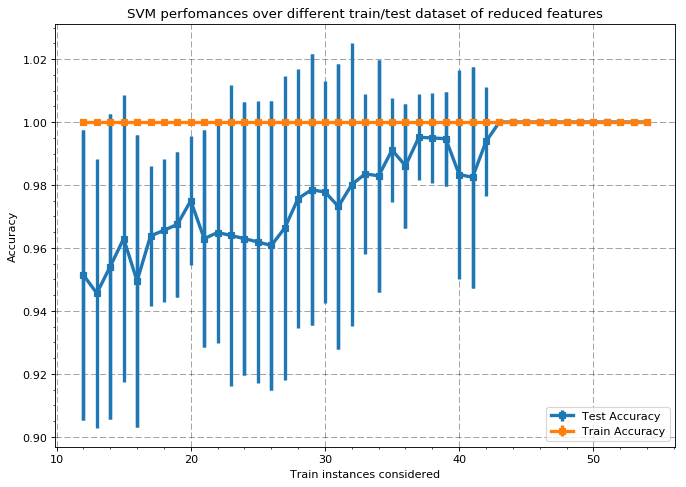

In [16]:
para = {'C' : 1, 'kernel' : 'linear', 'gamma' : 'auto' } #parameters of the SVM

reducer = SelectKBest(f_classif, 61)
feature_dataset_reduced = reducer.fit_transform(feature_dataset_full, labels)

performance_assesment_fraction_std(feature_dataset_reduced, labels, 9, para)